# Image Rotations: STL-10 + PyTorch

referring to the research paper _Unsupervised Representation Learning by Predicting Image Rotations_ by Spyros Gidaris et al.

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle, imageio

/home/majumdar/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/majumdar/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/majumdar/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# print(torch.cuda.memory_summary())
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.0+cu117
Number of GPU(s) available = 4
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX TITAN X
Available device is cuda


In [3]:
# Specify training hyper-parameters-
batch_size = 64
num_epochs = 100

In [4]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        # A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        # A.HorizontalFlip(p = 0.5),
        # A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)


In [5]:
class STL10Dataset(Dataset):
    '''
    Custom STL-10 dataset only for unlabeled data!
    '''
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir,
        self.transform = transform
    
    def __len__(self):
        totalFiles = 0
        totalDir = 0
        for base, dirs, files in os.walk(root_dir):
            # print(f'Searching in : {base}')
            for directories in dirs:
                totalDir += 1
            for Files in files:
                totalFiles += 1
        
        return totalFiles
    
    def __getitem__(self, idx):
        idx = idx + 1
        image = imageio.v3.imread(self.root_dir[0] + "unlabeled_image_png_" + str(idx) + ".png")
        
        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]
            
            # Randomly select 0, 1, 2 or 3 for image rotation-
            ang = np.random.randint(low = 0, high = 4, size = None)
            image = TF.rotate(img = image, angle = ang * 90)
            
        # return image, label
        return image, ang

        

In [6]:
# Specify STL-10 unlabeled data directory-
root_dir = "/home/majumdar/Downloads/.data/stl10_binary/unlabeled/"

In [7]:
# Create training data-
unlabeled_data = STL10Dataset(
    root_dir = root_dir, transform = transform_train
)

In [8]:
# Create data loader-
unlabeled_loader = torch.utils.data.DataLoader(
    dataset = unlabeled_data, batch_size = batch_size,
    shuffle = True
)

In [ ]:
"""
# Sanity check-
img, y = next(iter(unlabeled_loader))

img.shape, y.shape
# img.shape, y.shape

# Unnormalize images-
img = img / 2 + 0.5

# Transpose axes for visualization-
img = np.transpose(img.numpy(), (0, 2, 3, 1))

img.shape
# (128, 96, 96, 3)
"""

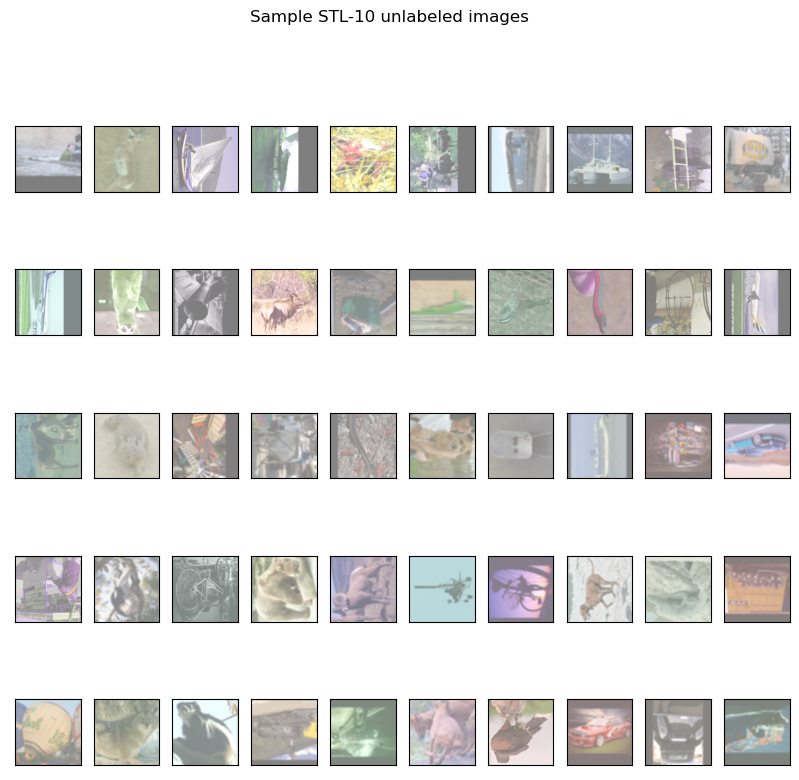

In [12]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(img[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Sample STL-10 unlabeled images")
plt.show()

In [ ]:
# del img, y

In [9]:
class ResNet_Block(nn.Module):
   
    def __init__(
        self, num_inp_channels,
        num_channels, num_bottleneck_channels,
        stride = 1, dropout = 0.2,
        use_1x1_conv = False, first_resblock = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.num_bottleneck_channels = num_bottleneck_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
        self.first_resblock = first_resblock
    
        if self.first_resblock:
            self.conv1 = nn.Conv2d(
                in_channels = self.num_inp_channels, out_channels = self.num_bottleneck_channels,
                kernel_size = 1, padding = 0,
                stride = self.stride, bias = False
            )
            self.bn1 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        else:
            self.conv1 = nn.Conv2d(
                in_channels = self.num_inp_channels, out_channels = self.num_bottleneck_channels,
                kernel_size = 1, padding = 0,
                stride = self.stride, bias = False
            )
            self.bn1 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_bottleneck_channels, out_channels = self.num_bottleneck_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        self.conv3 = nn.Conv2d(
            in_channels = self.num_bottleneck_channels, out_channels = self.num_channels,
            kernel_size = 1, padding = 0,
            stride = 1, bias = False
        )
        self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        if self.use_1x1_conv:
            self.conv4 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn4 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        y = self.dropout(F.leaky_relu(self.bn3(self.conv3(y))))
        
        if self.use_1x1_conv:
            x = self.bn4(self.conv4(x))
            
        y += x
        # return F.relu(self.dropout(y))
        return F.leaky_relu(y)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = self.bn1(self.conv1(x))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        y = self.bn3(self.conv3(y))
        print(f"Third conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn4(self.conv4(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [10]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = True
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock3 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock4 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            num_bottleneck_channels = 128, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock5 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock6 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock7 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock10 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock11 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock12 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock13 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock14 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock15 = ResNet_Block(
            num_inp_channels = 2048, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock16 = ResNet_Block(
            num_inp_channels = 2048, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        self.output_layer = nn.Linear(in_features = 2048, out_features = 4)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.resblock15(x)
        x = self.resblock16(x)
        x = self.avg_pool(x).squeeze()
        x = self.output_layer(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = F.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {x.shape}")
        x = self.resblock1(x)
        print(f"ResBlock 1 output shape: {x.shape}")
        x = self.resblock2(x)
        print(f"ResBlock 2 output shape: {x.shape}")
        x = self.resblock3(x)
        print(f"ResBlock 3 output shape: {x.shape}")
        x = self.resblock4(x)
        print(f"ResBlock 4 output shape: {x.shape}")
        x = self.resblock5(x)
        print(f"ResBlock 5 output shape: {x.shape}")
        x = self.resblock6(x)
        print(f"ResBlock 6 output shape: {x.shape}")
        x = self.resblock7(x)
        print(f"ResBlock 7 output shape: {x.shape}")
        x = self.resblock8(x)
        print(f"ResBlock 8 output shape: {x.shape}")
        x = self.resblock9(x)
        print(f"ResBlock 9 output shape: {x.shape}")
        x = self.resblock10(x)
        print(f"ResBlock 10 output shape: {x.shape}")
        x = self.resblock11(x)
        print(f"ResBlock 11 output shape: {x.shape}")
        x = self.resblock12(x)
        print(f"ResBlock 12 output shape: {x.shape}")
        x = self.resblock13(x)
        print(f"ResBlock 13 output shape: {x.shape}")
        x = self.resblock14(x)
        print(f"ResBlock 14 output shape: {x.shape}")
        x = self.resblock15(x)
        print(f"ResBlock 15 output shape: {x.shape}")
        x = self.resblock16(x)
        print(f"ResBlock 16 output shape: {x.shape}")
        x = self.avg_pool(x).squeeze()
        print(f"Average pool output shape: {x.shape}")
        x = self.output_layer(x)
        print(f"Output layer shape: {x.shape}")
        del x
        return None
    

In [11]:
# Initialize ResNet-50 architecture-
model = ResNet50()

In [12]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"Total number of trainable parameters in ResNet-50 CNN = {tot_params}")

Total number of trainable parameters in ResNet-50 CNN = 38080068


In [13]:
# Save random initial weights-
# torch.save(model.state_dict(), 'ResNet50_STL10_RotNet-Random_Weights.pth')

# Load randomly initialised weights-
model.load_state_dict(torch.load('ResNet50_STL10_RotNet-Random_Weights.pth'))

<All keys matched successfully>

In [14]:
# Use data parallelism, specify GPUs to use-
model = torch.nn.DataParallel(model, device_ids = [0, 1, 2, 3])

# Move to CUDA GPU-
model.to(0)

DataParallel(
  (module): ResNet50(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (resblock1): ResNet_Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )

In [15]:
# Define loss function and optimizer-
cost_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 5e-4)

In [16]:
# Decay lr at specified epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [30, 50, 70, 90],
    gamma = 0.1
)

In [17]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    # Place model to device-
    # model.to(device)
    # model.to(0)
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            # Push to CUDA GPU-
            images = images.to(0)
            labels = labels.to(0)
            # images = images.to(device)
            # labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = cost_fn(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [ ]:
"""
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                # Push to CUDA GPU-
                images = images.to(0)
                labels = labels.to(0)
                # images = images.to(device)
                # labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
                
                # Place model to device-
                # model.to(device)
                # model.to(0)
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = cost_fn(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()
"""

In [18]:
# Python3 dict to contain training metrics-
training_history = {}

# Initialize parameters saving 'best' models-
best_train_acc = 50

In [19]:
for epoch in range(1, num_epochs + 1):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = unlabeled_loader,
        train_dataset = unlabeled_data
    )
    """
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = test_loader,
        test_dataset = test_loader
    )
    """
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          # f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}%
          f" & LR = {current_lr:.8f}"
         )
    
    # Save training metrics to Python3 dict-
    training_history[epoch] = {
        'train_loss': train_loss, 'train_acc': train_acc,
        # 'val_loss': val_loss, 'val_acc': val_acc,
        'lr': current_lr
    }

    # Save best weights achieved until now-
    if (train_acc > best_train_acc):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_train_acc = train_acc

        print(f"Saving model with highest train acc = {train_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet50_STL10_RotNet_best_acc.pth")
        

Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:41<00:00,  2.21s/batch, accuracy=25.5, loss=1.48]


Epoch: 1; loss = 1.4784, acc = 25.51%  & LR = 0.10000000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:17<00:00,  2.28s/batch, accuracy=31.5, loss=1.3]


Epoch: 2; loss = 1.3046, acc = 31.54%  & LR = 0.10000000


Training: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:46<00:00,  2.33s/batch, accuracy=39.3, loss=1.18]


Epoch: 3; loss = 1.1826, acc = 39.28%  & LR = 0.10000000


Training: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:10<00:00,  2.31s/batch, accuracy=49.5, loss=1.11]


Epoch: 4; loss = 1.1135, acc = 49.54%  & LR = 0.10000000


Training: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:24<00:00,  2.32s/batch, accuracy=52.1, loss=1.08]


Epoch: 5; loss = 1.0821, acc = 52.12%  & LR = 0.10000000
Saving model with highest train acc = 52.12%



Training: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:01:13<00:00,  2.35s/batch, accuracy=53.7, loss=1.06]


Epoch: 6; loss = 1.0599, acc = 53.68%  & LR = 0.10000000
Saving model with highest train acc = 53.68%



Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:01<00:00,  2.30s/batch, accuracy=55, loss=1.04]


Epoch: 7; loss = 1.0427, acc = 55.03%  & LR = 0.10000000
Saving model with highest train acc = 55.03%



Training: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:18<00:00,  2.32s/batch, accuracy=56.9, loss=1.01]


Epoch: 8; loss = 1.0145, acc = 56.94%  & LR = 0.10000000
Saving model with highest train acc = 56.94%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:30<00:00,  2.32s/batch, accuracy=59, loss=0.984]


Epoch: 9; loss = 0.9837, acc = 59.01%  & LR = 0.10000000
Saving model with highest train acc = 59.01%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:36<00:00,  2.33s/batch, accuracy=59.4, loss=0.974]


Epoch: 10; loss = 0.9735, acc = 59.40%  & LR = 0.10000000
Saving model with highest train acc = 59.40%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:39<00:00,  2.33s/batch, accuracy=59.9, loss=0.961]


Epoch: 11; loss = 0.9607, acc = 59.87%  & LR = 0.10000000
Saving model with highest train acc = 59.87%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:07<00:00,  2.31s/batch, accuracy=60.3, loss=0.953]


Epoch: 12; loss = 0.9529, acc = 60.34%  & LR = 0.10000000
Saving model with highest train acc = 60.34%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:26<00:00,  2.32s/batch, accuracy=60.6, loss=0.949]


Epoch: 13; loss = 0.9490, acc = 60.64%  & LR = 0.10000000
Saving model with highest train acc = 60.64%



Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:32<00:00,  2.32s/batch, accuracy=61, loss=0.94]


Epoch: 14; loss = 0.9403, acc = 60.98%  & LR = 0.10000000
Saving model with highest train acc = 60.98%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:49<00:00,  2.33s/batch, accuracy=61.4, loss=0.937]


Epoch: 15; loss = 0.9369, acc = 61.36%  & LR = 0.10000000
Saving model with highest train acc = 61.36%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:26<00:00,  2.32s/batch, accuracy=61.4, loss=0.936]


Epoch: 16; loss = 0.9360, acc = 61.37%  & LR = 0.10000000
Saving model with highest train acc = 61.37%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:02:24<00:00,  2.40s/batch, accuracy=61.5, loss=0.932]


Epoch: 17; loss = 0.9321, acc = 61.54%  & LR = 0.10000000
Saving model with highest train acc = 61.54%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:33<00:00,  2.32s/batch, accuracy=61.5, loss=0.933]


Epoch: 18; loss = 0.9326, acc = 61.48%  & LR = 0.10000000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:42<00:00,  2.33s/batch, accuracy=61.9, loss=0.926]


Epoch: 19; loss = 0.9263, acc = 61.89%  & LR = 0.10000000
Saving model with highest train acc = 61.89%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:09<00:00,  2.31s/batch, accuracy=62.1, loss=0.925]


Epoch: 20; loss = 0.9249, acc = 62.06%  & LR = 0.10000000
Saving model with highest train acc = 62.06%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:28<00:00,  2.32s/batch, accuracy=62.1, loss=0.919]


Epoch: 21; loss = 0.9188, acc = 62.14%  & LR = 0.10000000
Saving model with highest train acc = 62.14%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:22<00:00,  2.32s/batch, accuracy=62, loss=0.922]


Epoch: 22; loss = 0.9215, acc = 62.04%  & LR = 0.10000000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:10<00:00,  2.31s/batch, accuracy=62.5, loss=0.915]


Epoch: 23; loss = 0.9152, acc = 62.51%  & LR = 0.10000000
Saving model with highest train acc = 62.51%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:29<00:00,  2.32s/batch, accuracy=62.5, loss=0.914]


Epoch: 24; loss = 0.9144, acc = 62.51%  & LR = 0.10000000
Saving model with highest train acc = 62.51%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:01:06<00:00,  2.35s/batch, accuracy=62.6, loss=0.914]


Epoch: 25; loss = 0.9137, acc = 62.55%  & LR = 0.10000000
Saving model with highest train acc = 62.55%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:19<00:00,  2.32s/batch, accuracy=62.6, loss=0.914]


Epoch: 26; loss = 0.9143, acc = 62.62%  & LR = 0.10000000
Saving model with highest train acc = 62.62%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:03<00:00,  2.31s/batch, accuracy=62.9, loss=0.911]


Epoch: 27; loss = 0.9112, acc = 62.92%  & LR = 0.10000000
Saving model with highest train acc = 62.92%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:22<00:00,  2.32s/batch, accuracy=62.6, loss=0.916]


Epoch: 28; loss = 0.9156, acc = 62.56%  & LR = 0.10000000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:49<00:00,  2.30s/batch, accuracy=62.8, loss=0.907]


Epoch: 29; loss = 0.9075, acc = 62.81%  & LR = 0.10000000


Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:30<00:00,  2.21s/batch, accuracy=62.7, loss=0.91]


Epoch: 30; loss = 0.9099, acc = 62.74%  & LR = 0.01000000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [55:55<00:00,  2.15s/batch, accuracy=69.5, loss=0.767]


Epoch: 31; loss = 0.7669, acc = 69.51%  & LR = 0.01000000
Saving model with highest train acc = 69.51%



Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [55:33<00:00,  2.13s/batch, accuracy=71.1, loss=0.73]


Epoch: 32; loss = 0.7296, acc = 71.06%  & LR = 0.01000000
Saving model with highest train acc = 71.06%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [55:49<00:00,  2.14s/batch, accuracy=72, loss=0.712]


Epoch: 33; loss = 0.7124, acc = 72.03%  & LR = 0.01000000
Saving model with highest train acc = 72.03%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [56:26<00:00,  2.17s/batch, accuracy=72.5, loss=0.701]


Epoch: 34; loss = 0.7008, acc = 72.51%  & LR = 0.01000000
Saving model with highest train acc = 72.51%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:01<00:00,  2.19s/batch, accuracy=72.8, loss=0.694]


Epoch: 35; loss = 0.6940, acc = 72.82%  & LR = 0.01000000
Saving model with highest train acc = 72.82%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [58:53<00:00,  2.26s/batch, accuracy=73.1, loss=0.687]


Epoch: 36; loss = 0.6874, acc = 73.08%  & LR = 0.01000000
Saving model with highest train acc = 73.08%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:12<00:00,  2.43s/batch, accuracy=73.5, loss=0.677]


Epoch: 37; loss = 0.6772, acc = 73.47%  & LR = 0.01000000
Saving model with highest train acc = 73.47%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:48<00:00,  2.45s/batch, accuracy=73.8, loss=0.673]


Epoch: 38; loss = 0.6733, acc = 73.81%  & LR = 0.01000000
Saving model with highest train acc = 73.81%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:10<00:00,  2.43s/batch, accuracy=74, loss=0.666]


Epoch: 39; loss = 0.6660, acc = 74.04%  & LR = 0.01000000
Saving model with highest train acc = 74.04%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:16<00:00,  2.43s/batch, accuracy=74.2, loss=0.662]


Epoch: 40; loss = 0.6623, acc = 74.16%  & LR = 0.01000000
Saving model with highest train acc = 74.16%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:28<00:00,  2.44s/batch, accuracy=74.6, loss=0.652]


Epoch: 41; loss = 0.6524, acc = 74.63%  & LR = 0.01000000
Saving model with highest train acc = 74.63%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:02:29<00:00,  2.40s/batch, accuracy=74.7, loss=0.648]


Epoch: 42; loss = 0.6477, acc = 74.68%  & LR = 0.01000000
Saving model with highest train acc = 74.68%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:40<00:00,  2.44s/batch, accuracy=75.1, loss=0.641]


Epoch: 43; loss = 0.6412, acc = 75.08%  & LR = 0.01000000
Saving model with highest train acc = 75.08%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:02:45<00:00,  2.41s/batch, accuracy=75.4, loss=0.638]


Epoch: 44; loss = 0.6377, acc = 75.40%  & LR = 0.01000000
Saving model with highest train acc = 75.40%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:11<00:00,  2.43s/batch, accuracy=75.7, loss=0.629]


Epoch: 45; loss = 0.6288, acc = 75.72%  & LR = 0.01000000
Saving model with highest train acc = 75.72%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:03:17<00:00,  2.43s/batch, accuracy=75.7, loss=0.626]


Epoch: 46; loss = 0.6258, acc = 75.68%  & LR = 0.01000000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:41<00:00,  2.29s/batch, accuracy=75.9, loss=0.621]


Epoch: 47; loss = 0.6208, acc = 75.93%  & LR = 0.01000000
Saving model with highest train acc = 75.93%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:46<00:00,  2.29s/batch, accuracy=76.5, loss=0.612]


Epoch: 48; loss = 0.6118, acc = 76.54%  & LR = 0.01000000
Saving model with highest train acc = 76.54%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:11<00:00,  2.27s/batch, accuracy=76.5, loss=0.609]


Epoch: 49; loss = 0.6088, acc = 76.48%  & LR = 0.01000000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:18<00:00,  2.28s/batch, accuracy=76.8, loss=0.606]


Epoch: 50; loss = 0.6056, acc = 76.77%  & LR = 0.00100000
Saving model with highest train acc = 76.77%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:29<00:00,  2.28s/batch, accuracy=80, loss=0.525]


Epoch: 51; loss = 0.5254, acc = 79.96%  & LR = 0.00100000
Saving model with highest train acc = 79.96%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:29<00:00,  2.28s/batch, accuracy=81, loss=0.5]


Epoch: 52; loss = 0.4999, acc = 81.02%  & LR = 0.00100000
Saving model with highest train acc = 81.02%



Training: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:23<00:00,  2.32s/batch, accuracy=81.5, loss=0.49]


Epoch: 53; loss = 0.4896, acc = 81.48%  & LR = 0.00100000
Saving model with highest train acc = 81.48%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:09<00:00,  2.31s/batch, accuracy=81.7, loss=0.483]


Epoch: 54; loss = 0.4835, acc = 81.66%  & LR = 0.00100000
Saving model with highest train acc = 81.66%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:40<00:00,  2.29s/batch, accuracy=82, loss=0.478]


Epoch: 55; loss = 0.4777, acc = 81.98%  & LR = 0.00100000
Saving model with highest train acc = 81.98%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:24<00:00,  2.32s/batch, accuracy=82.1, loss=0.474]


Epoch: 56; loss = 0.4737, acc = 82.11%  & LR = 0.00100000
Saving model with highest train acc = 82.11%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:55<00:00,  2.30s/batch, accuracy=82.3, loss=0.469]


Epoch: 57; loss = 0.4689, acc = 82.33%  & LR = 0.00100000
Saving model with highest train acc = 82.33%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:20<00:00,  2.32s/batch, accuracy=82.6, loss=0.462]


Epoch: 58; loss = 0.4623, acc = 82.56%  & LR = 0.00100000
Saving model with highest train acc = 82.56%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:02:02<00:00,  2.38s/batch, accuracy=82.6, loss=0.458]


Epoch: 59; loss = 0.4581, acc = 82.59%  & LR = 0.00100000
Saving model with highest train acc = 82.59%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:02:53<00:00,  2.41s/batch, accuracy=82.9, loss=0.455]


Epoch: 60; loss = 0.4553, acc = 82.87%  & LR = 0.00100000
Saving model with highest train acc = 82.87%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:01:54<00:00,  2.38s/batch, accuracy=83.1, loss=0.452]


Epoch: 61; loss = 0.4517, acc = 83.12%  & LR = 0.00100000
Saving model with highest train acc = 83.12%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:02:01<00:00,  2.38s/batch, accuracy=83.2, loss=0.447]


Epoch: 62; loss = 0.4474, acc = 83.17%  & LR = 0.00100000
Saving model with highest train acc = 83.17%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:01:40<00:00,  2.37s/batch, accuracy=83.3, loss=0.445]


Epoch: 63; loss = 0.4450, acc = 83.34%  & LR = 0.00100000
Saving model with highest train acc = 83.34%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:02:06<00:00,  2.38s/batch, accuracy=83.5, loss=0.442]


Epoch: 64; loss = 0.4418, acc = 83.47%  & LR = 0.00100000
Saving model with highest train acc = 83.47%



Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [58:16<00:00,  2.24s/batch, accuracy=83.5, loss=0.44]


Epoch: 65; loss = 0.4400, acc = 83.45%  & LR = 0.00100000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:54<00:00,  2.22s/batch, accuracy=83.5, loss=0.439]


Epoch: 66; loss = 0.4392, acc = 83.48%  & LR = 0.00100000
Saving model with highest train acc = 83.48%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:56<00:00,  2.22s/batch, accuracy=83.7, loss=0.433]


Epoch: 67; loss = 0.4334, acc = 83.71%  & LR = 0.00100000
Saving model with highest train acc = 83.71%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:16<00:00,  2.20s/batch, accuracy=83.7, loss=0.434]


Epoch: 68; loss = 0.4336, acc = 83.74%  & LR = 0.00100000
Saving model with highest train acc = 83.74%



Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:45<00:00,  2.22s/batch, accuracy=83.9, loss=0.43]


Epoch: 69; loss = 0.4299, acc = 83.85%  & LR = 0.00100000
Saving model with highest train acc = 83.85%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:39<00:00,  2.21s/batch, accuracy=84, loss=0.427]


Epoch: 70; loss = 0.4267, acc = 84.03%  & LR = 0.00010000
Saving model with highest train acc = 84.03%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [58:00<00:00,  2.23s/batch, accuracy=85, loss=0.404]


Epoch: 71; loss = 0.4044, acc = 84.99%  & LR = 0.00010000
Saving model with highest train acc = 84.99%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:47<00:00,  2.22s/batch, accuracy=85.3, loss=0.397]


Epoch: 72; loss = 0.3968, acc = 85.27%  & LR = 0.00010000
Saving model with highest train acc = 85.27%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [58:02<00:00,  2.23s/batch, accuracy=85.3, loss=0.396]


Epoch: 73; loss = 0.3964, acc = 85.26%  & LR = 0.00010000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:32<00:00,  2.21s/batch, accuracy=85.4, loss=0.394]


Epoch: 74; loss = 0.3945, acc = 85.38%  & LR = 0.00010000
Saving model with highest train acc = 85.38%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [58:13<00:00,  2.24s/batch, accuracy=85.4, loss=0.392]


Epoch: 75; loss = 0.3915, acc = 85.40%  & LR = 0.00010000
Saving model with highest train acc = 85.40%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:56<00:00,  2.22s/batch, accuracy=85.4, loss=0.392]


Epoch: 76; loss = 0.3923, acc = 85.44%  & LR = 0.00010000
Saving model with highest train acc = 85.44%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:37<00:00,  2.21s/batch, accuracy=85.7, loss=0.389]


Epoch: 77; loss = 0.3893, acc = 85.69%  & LR = 0.00010000
Saving model with highest train acc = 85.69%



Training: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:18<00:00,  2.20s/batch, accuracy=85.5, loss=0.39]


Epoch: 78; loss = 0.3900, acc = 85.54%  & LR = 0.00010000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:40<00:00,  2.21s/batch, accuracy=85.7, loss=0.386]


Epoch: 79; loss = 0.3862, acc = 85.66%  & LR = 0.00010000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:44<00:00,  2.22s/batch, accuracy=85.7, loss=0.385]


Epoch: 80; loss = 0.3850, acc = 85.70%  & LR = 0.00010000
Saving model with highest train acc = 85.70%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [57:30<00:00,  2.21s/batch, accuracy=85.7, loss=0.385]


Epoch: 81; loss = 0.3849, acc = 85.66%  & LR = 0.00010000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:50<00:00,  2.30s/batch, accuracy=85.8, loss=0.384]


Epoch: 82; loss = 0.3843, acc = 85.75%  & LR = 0.00010000
Saving model with highest train acc = 85.75%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:00<00:00,  2.30s/batch, accuracy=85.7, loss=0.382]


Epoch: 83; loss = 0.3822, acc = 85.70%  & LR = 0.00010000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:44<00:00,  2.33s/batch, accuracy=85.9, loss=0.383]


Epoch: 84; loss = 0.3826, acc = 85.92%  & LR = 0.00010000
Saving model with highest train acc = 85.92%



Training: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:42<00:00,  2.33s/batch, accuracy=85.8, loss=0.38]


Epoch: 85; loss = 0.3804, acc = 85.84%  & LR = 0.00010000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:57<00:00,  2.34s/batch, accuracy=85.8, loss=0.379]


Epoch: 86; loss = 0.3792, acc = 85.85%  & LR = 0.00010000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:43<00:00,  2.29s/batch, accuracy=85.9, loss=0.379]


Epoch: 87; loss = 0.3787, acc = 85.94%  & LR = 0.00010000
Saving model with highest train acc = 85.94%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:22<00:00,  2.32s/batch, accuracy=86, loss=0.379]


Epoch: 88; loss = 0.3790, acc = 85.98%  & LR = 0.00010000
Saving model with highest train acc = 85.98%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:13<00:00,  2.31s/batch, accuracy=86, loss=0.377]


Epoch: 89; loss = 0.3775, acc = 86.04%  & LR = 0.00010000
Saving model with highest train acc = 86.04%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:10<00:00,  2.31s/batch, accuracy=86, loss=0.377]


Epoch: 90; loss = 0.3767, acc = 86.04%  & LR = 0.00001000
Saving model with highest train acc = 86.04%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:52<00:00,  2.34s/batch, accuracy=86.1, loss=0.374]


Epoch: 91; loss = 0.3743, acc = 86.09%  & LR = 0.00001000
Saving model with highest train acc = 86.09%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:20<00:00,  2.32s/batch, accuracy=86.1, loss=0.375]


Epoch: 92; loss = 0.3752, acc = 86.09%  & LR = 0.00001000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:09<00:00,  2.31s/batch, accuracy=86.2, loss=0.373]


Epoch: 93; loss = 0.3731, acc = 86.20%  & LR = 0.00001000
Saving model with highest train acc = 86.20%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:01:30<00:00,  2.36s/batch, accuracy=86.1, loss=0.372]


Epoch: 94; loss = 0.3725, acc = 86.13%  & LR = 0.00001000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:01:30<00:00,  2.36s/batch, accuracy=86.2, loss=0.373]


Epoch: 95; loss = 0.3733, acc = 86.22%  & LR = 0.00001000
Saving model with highest train acc = 86.22%



Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:01:11<00:00,  2.35s/batch, accuracy=86.2, loss=0.373]


Epoch: 96; loss = 0.3727, acc = 86.24%  & LR = 0.00001000
Saving model with highest train acc = 86.24%



Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:51<00:00,  2.30s/batch, accuracy=86.1, loss=0.374]


Epoch: 97; loss = 0.3740, acc = 86.13%  & LR = 0.00001000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:36<00:00,  2.29s/batch, accuracy=86.2, loss=0.373]


Epoch: 98; loss = 0.3730, acc = 86.19%  & LR = 0.00001000


Training: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [59:26<00:00,  2.28s/batch, accuracy=86.1, loss=0.373]


Epoch: 99; loss = 0.3732, acc = 86.11%  & LR = 0.00001000


Training: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [1:00:37<00:00,  2.33s/batch, accuracy=86.3, loss=0.372]


Epoch: 100; loss = 0.3721, acc = 86.25%  & LR = 0.00001000
Saving model with highest train acc = 86.25%



In [21]:
torch.save(model.state_dict(), "ResNet50_STL10_RotNet_last_epoch.pth")

In [20]:
# Save training history as pickle file-
with open("STL10_ResNet50_Pretraining_history.pkl", "wb") as file:
    pickle.dump(training_history, file)